In [21]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import trange
from utils import *
%matplotlib inline

In [22]:
image_shape = (48, 48)
val_split = 0.25
batch_size = 16
max_steps = 3000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_to_idx = {'angry': 0, 'clenched_teeth': 1, 'cringe': 2, 'disgust': 3, 'eye_roll': 4, 'here_we_go': 5, 'kiss': 6, 'sad': 7, 'surprise': 8, 'very_sad': 9}

In [23]:
data_dir = 'generated/csawgan_gp/'
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        print(f'{folder}: {len(os.listdir(os.path.join(data_dir, folder)))}')
classes = os.listdir(data_dir)

here_we_go: 680
kiss: 504
disgust: 712
cringe: 709
sad: 644
angry: 694
surprise: 692
clenched_teeth: 624
eye_roll: 647
very_sad: 670


In [24]:
train_tfms = tt.Compose([
    tt.Resize(image_shape), 
    tt.Grayscale(num_output_channels=1), 
    tt.ToTensor()
])

# all_data = ImageFolder(data_dir, transform=train_tfms)
# all_data = Subset(all_data, np.random.choice(len(all_data), 12000, replace=False))
# print(len(all_data))
# # train, val = torch.utils.data.random_split(all_data, [int((1-val_split)*len(all_data))+1, int(val_split*len(all_data))])
# train, val = torch.utils.data.random_split(all_data, [10000, 2000])
# train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True)
# val_dl = DataLoader(val, batch_size, shuffle=True, num_workers=3, pin_memory=True)

## Using a GPU

In [25]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device

device(type='cpu')

# Model

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        out = torch.nn.functional.softmax(out, dim=-1)
        return out

In [27]:
def load_ckpt(checkpoint_path, model): 
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
    return model

# Model inversion 
Code from Tim Gianitsos http://cs230.stanford.edu/projects_spring_2020/reports/38961673.pdf

In [28]:
def model_invert(label, max_steps, learning_rate, net):
    torch.set_grad_enabled(True)
    net.eval()
    x = torch.autograd.Variable(torch.zeros(size=(1, 1, 48, 48), dtype=torch.float,requires_grad=True), requires_grad=True)
    x_min = x
    c_min = float('inf')
    for step in trange(max_steps):
        net.zero_grad()
        cost = 1 - net(x)[0, label]
        cost.backward()
        x = torch.autograd.Variable(x - learning_rate * x.grad, requires_grad=True)
        if c_min > cost:
            c_min = cost
            x_min = x
#         if step % show_freq == 0: 
#             print(cost)
    plt.imshow(x_min.detach().numpy()[0][0], plt.cm.gray)
    plt.show()

In [29]:
model = to_device(ResNet(1, 10), device)
show_freq = 100

## WGAN_GP model

In [30]:
ckpt_path = './model_ckpt/emotion_detection_csawgan_gp.pth'
model = load_ckpt(ckpt_path, model)

100%|██████████| 3000/3000 [04:50<00:00, 10.31it/s]


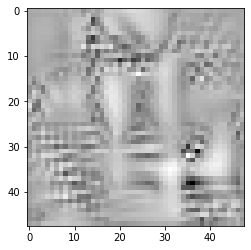

In [31]:
model_invert(class_to_idx['angry'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [06:13<00:00,  8.03it/s]


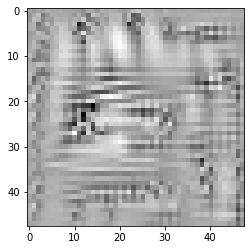

In [32]:
model_invert(class_to_idx['clenched_teeth'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:45<00:00, 10.51it/s]


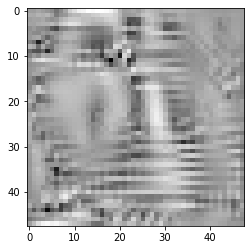

In [33]:
model_invert(class_to_idx['cringe'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:37<00:00, 10.82it/s]


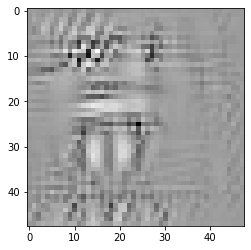

In [34]:
model_invert(class_to_idx['disgust'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:40<00:00, 10.68it/s]


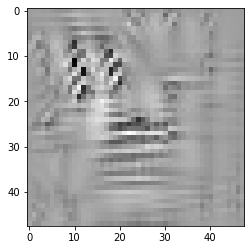

In [35]:
model_invert(class_to_idx['eye_roll'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:46<00:00, 10.48it/s]


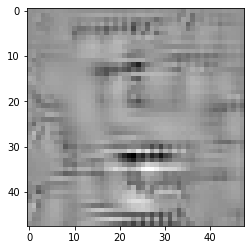

In [36]:
model_invert(class_to_idx['here_we_go'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:48<00:00, 10.39it/s]


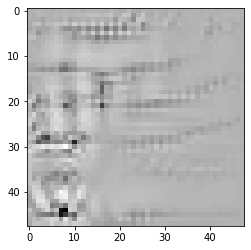

In [37]:
model_invert(class_to_idx['kiss'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:39<00:00, 10.73it/s]


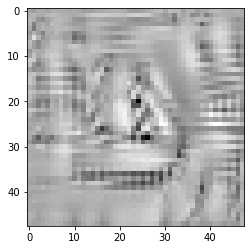

In [38]:
model_invert(class_to_idx['sad'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:38<00:00, 10.77it/s]


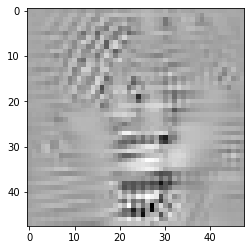

In [39]:
model_invert(class_to_idx['surprise'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:44<00:00, 10.53it/s]


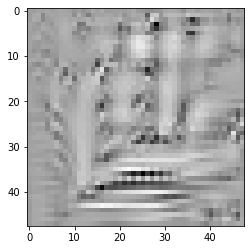

In [40]:
model_invert(class_to_idx['very_sad'], max_steps, 0.01, model)

## Original trained model

In [21]:
ckpt_path = './model_ckpt/emotion_detection_original.pth'
model = load_ckpt(ckpt_path, model)

100%|██████████| 3000/3000 [04:53<00:00, 10.24it/s]


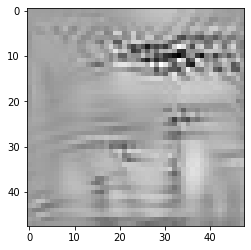

In [22]:
model_invert(class_to_idx['angry'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:12<00:00,  9.59it/s]


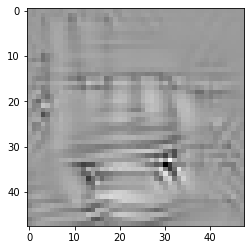

In [23]:
model_invert(class_to_idx['clenched_teeth'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:06<00:00,  9.78it/s]


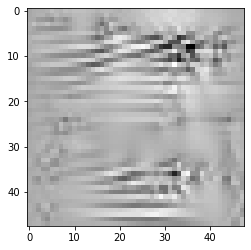

In [24]:
model_invert(class_to_idx['cringe'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:52<00:00, 10.26it/s]


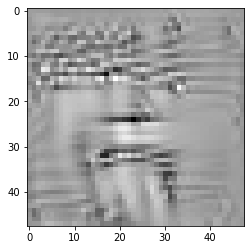

In [25]:
model_invert(class_to_idx['disgust'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:04<00:00,  9.85it/s]


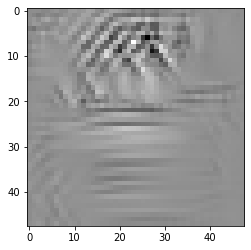

In [26]:
model_invert(class_to_idx['eye_roll'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:11<00:00,  9.63it/s]


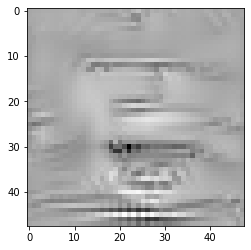

In [27]:
model_invert(class_to_idx['here_we_go'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:51<00:00, 10.28it/s]


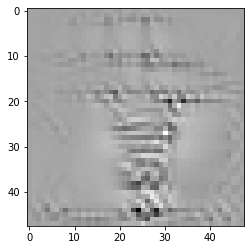

In [28]:
model_invert(class_to_idx['kiss'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:05<00:00,  9.82it/s]


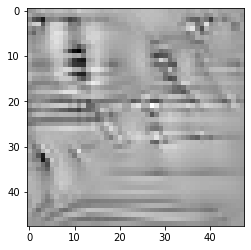

In [29]:
model_invert(class_to_idx['sad'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:47<00:00, 10.45it/s]


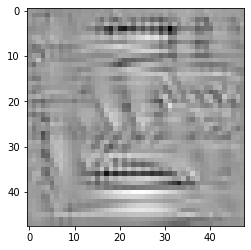

In [30]:
model_invert(class_to_idx['very_sad'], max_steps, 0.01, model)

In [ ]:
model_invert(class_to_idx['surprise'], max_steps, 0.01, model)

 15%|█▍        | 446/3000 [00:43<03:51, 11.02it/s]

In [21]:
ckpt_path = './model_ckpt/emotion_detection_original.pth'
model = load_ckpt(ckpt_path, model)

100%|██████████| 3000/3000 [04:53<00:00, 10.24it/s]


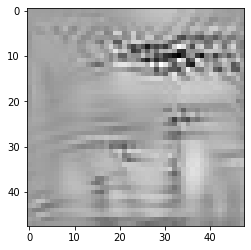

In [22]:
model_invert(class_to_idx['angry'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:12<00:00,  9.59it/s]


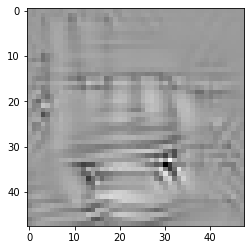

In [23]:
model_invert(class_to_idx['clenched_teeth'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:06<00:00,  9.78it/s]


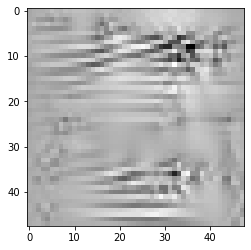

In [24]:
model_invert(class_to_idx['cringe'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:52<00:00, 10.26it/s]


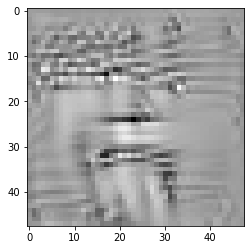

In [25]:
model_invert(class_to_idx['disgust'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:04<00:00,  9.85it/s]


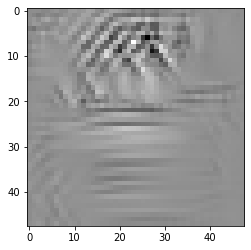

In [26]:
model_invert(class_to_idx['eye_roll'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:11<00:00,  9.63it/s]


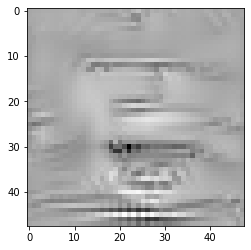

In [27]:
model_invert(class_to_idx['here_we_go'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:51<00:00, 10.28it/s]


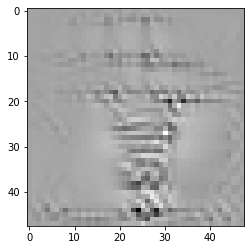

In [28]:
model_invert(class_to_idx['kiss'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [05:05<00:00,  9.82it/s]


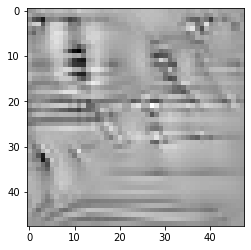

In [29]:
model_invert(class_to_idx['sad'], max_steps, 0.01, model)

100%|██████████| 3000/3000 [04:47<00:00, 10.45it/s]


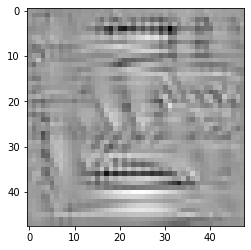

In [30]:
model_invert(class_to_idx['very_sad'], max_steps, 0.01, model)

In [ ]:
model_invert(class_to_idx['surprise'], max_steps, 0.01, model)

 15%|█▍        | 446/3000 [00:43<03:51, 11.02it/s]